Partiendo del problema base

$\frac{du}{dt} - \alpha \frac{d^2u}{dx^2} = 0$

$u(x, 0) = \cos(\frac{\pi x}{L})$

$u_x(0, t) = u_x(L, t) = 0$

se procederá a modificarlo de varias maneras.

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
from deepxde.backend import tf

En primer lugar, se modifica la ecuación:

$\frac{du}{dt} - \alpha \frac{d^2u}{dx^2} = x$

sin cambiar nada más.

In [5]:
# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx - x[:, 0:1]


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Parece ser necesario usar x[:, 0:1] en lugar de x[:, 0]. Si no, el error no consigue bajar de 1e-1.

In [6]:
## CHANGE INITIAL AND BOUNDARY CONDITIONS ##
## CHANGE INITIAL AND BOUNDARY CONDITIONS ##
# Initial and boundary conditions:
bc = dde.icbc.NeumannBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.cos(np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

In [7]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [8]:
# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.008021 s

Training model...



C:\Users\reloj\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Cause: could not parse the source code of <function <lambda> at 0x00000274A13E4DC0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x00000274A13E4DC0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                        Test loss                         Test metric
0         [1.59e-01, 3.81e-03, 5.32e-01]    [1.52e-01, 3.81e-03, 5.32e-01]    []  
1000      

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


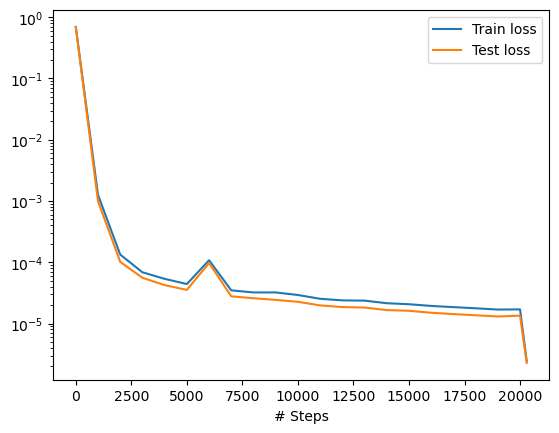

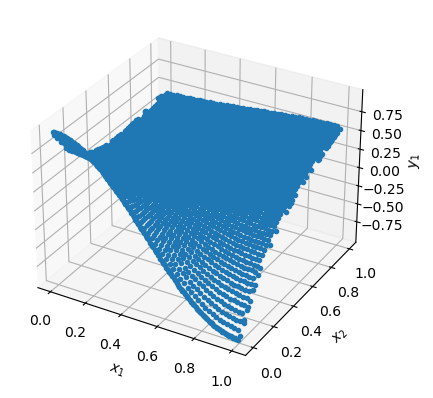

In [9]:
# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

A continuación, se vuelve a la ecuación original:

$\frac{du}{dt} - \alpha \frac{d^2u}{dx^2} = 0$

cambiando las condiciones de contorno:

$u_x(0, t) = -u_x(L, t) = \cos(t)$

con la misma condición inicial.

In [9]:
# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx # du_t - a*du_xx = 0


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Aquí se define una función $func(x, t) = \frac{L - 2x}{L} \cos(t)$ para cumplir las condiciones de contorno.

In [10]:
## CHANGE INITIAL AND BOUNDARY CONDITIONS ##
## CHANGE INITIAL AND BOUNDARY CONDITIONS ##
# Initial and boundary conditions:
def func(x):
    return (L - 2*x[:, 0:1])/L * np.cos(x[:, 1:2]) # (L - 2*x)/L * cos(t); x=0 -> cos(t); x=L -> -cos(t)

bc = dde.icbc.NeumannBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.cos(np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

In [11]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [12]:
# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.005520 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.00e-02, 1.17e-01, 3.96e-01]    [2.05e-02, 1.17e-01, 3.96e-01]    []  
1000      [2.89e-04, 4.34e-04, 8.81e-04]    [1.36e-04, 4.34e-04, 8.81e-04]    []  
2000      [1.06e-04, 3.31e-04, 8.03e-04]    [6.28e-05, 3.31e-04, 8.03e-04]    []  
3000      [9.95e-05, 2.46e-04, 8.10e-04]    [6.70e-05, 2.46e-04, 8.10e-04]    []  
4000      [1.01e-04, 2.06e-04, 8.10e-04]    [7.07e-05, 2.06e-04, 8.10e-04]    []  
5000      [1.00e-04, 1.85e-04, 8.04e-04]    [7.14e-05, 1.85e-04, 8.04e-04]    []  
6000      [9.80e-05, 1.71e-04, 7.92e-04]    [7.06e-05, 1.71e-04, 7.92e-04]    []  
7000      [9.64e-05, 1.62e-04, 7.75e-04]    [7.06e-05, 1.62e-04, 7.75e-04]    []  
8000      [2.25e-04, 1.78e-04, 7.58e-04]    [1.78e-04, 1.78e-04, 7.58e-04]    []  
9000      [2.62e-04, 2.25e-04, 8.06e-04]    [2.07e-04, 2.25e-04, 8.06e-04]    []  
10000     [8.63

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


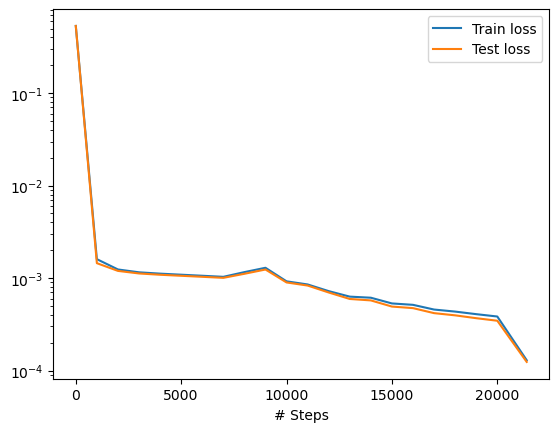

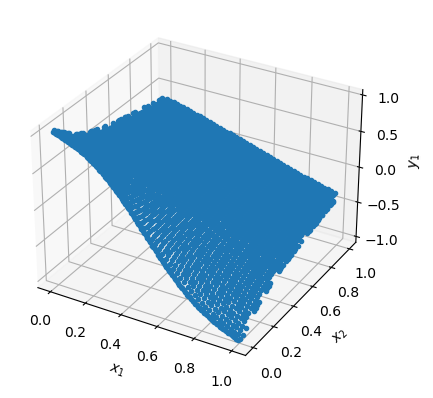

In [13]:
# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

En el siguiente problema se vuelve a las condiciones de contorno originales pero modificando la ecuación:

$\frac{du}{dt} - \alpha \frac{d}{dx} \left(x \frac{du}{dx}\right) = 0$

In [26]:
# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    ady_x = dy_x * x[:, 0:1]
    dy_xx = dde.grad.jacobian(ady_x, x, i=0, j=0)
    return dy_t - a * dy_xx


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [27]:
## CHANGE INITIAL AND BOUNDARY CONDITIONS ##
## CHANGE INITIAL AND BOUNDARY CONDITIONS ##
# Initial and boundary conditions:
bc = dde.icbc.NeumannBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.cos(np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

In [28]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [29]:
# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.003971 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.51e-01, 3.18e-01, 3.96e-01]    [1.54e-01, 3.18e-01, 3.96e-01]    []  
1000      [1.42e-02, 1.48e-03, 8.95e-04]    [5.24e-03, 1.48e-03, 8.95e-04]    []  
2000      [9.17e-03, 3.98e-04, 6.02e-04]    [1.99e-03, 3.98e-04, 6.02e-04]    []  
3000      [7.86e-03, 3.48e-04, 5.54e-04]    [1.53e-03, 3.48e-04, 5.54e-04]    []  
4000      [7.77e-03, 1.70e-03, 6.95e-04]    [1.25e-03, 1.70e-03, 6.95e-04]    []  
5000      [6.81e-03, 1.60e-04, 5.22e-04]    [1.16e-03, 1.60e-04, 5.22e-04]    []  
6000      [6.79e-03, 1.66e-04, 5.64e-04]    [1.08e-03, 1.66e-04, 5.64e-04]    []  
7000      [6.60e-03, 5.27e-05, 5.21e-04]    [1.06e-03, 5.27e-05, 5.21e-04]    []  
8000      [6.07e-03, 1.91e-03, 4.49e-04]    [1.17e-03, 1.91e-03, 4.49e-04]    []  
9000      [6.37e-03, 7.40e-05, 4.72e-04]    [1.14e-03, 7.40e-05, 4.72e-04]    []  
10000     [6.29

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


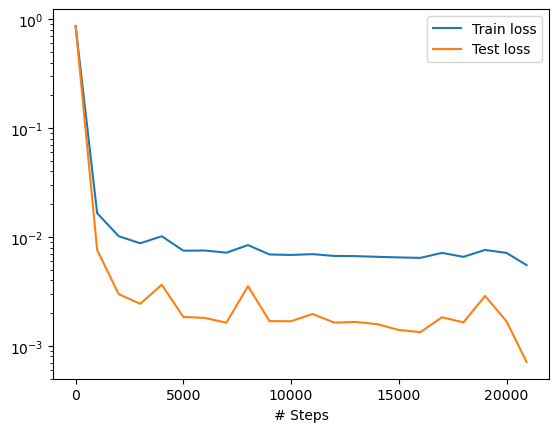

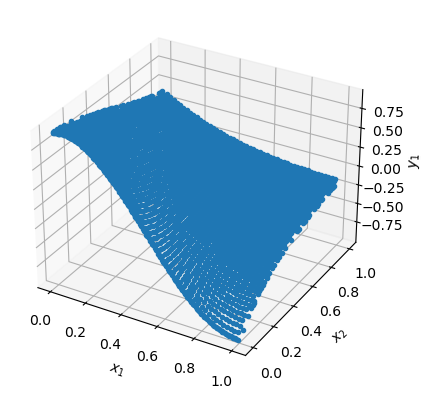

In [30]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

La siguiente red se entrena para la ecuación no lineal:

$\frac{du}{dt} - \alpha \frac{d}{dx} \left(u \frac{du}{dx}\right) = 0$

con las condiciones de contorno originales.

In [31]:
# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    ady_x = y * x[:, 0:1]
    dy_xx = dde.grad.jacobian(ady_x, x, i=0, j=0)
    return dy_t - a * dy_xx # du_t - a*d(u*du_x)_x = 0


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [32]:
## CHANGE INITIAL AND BOUNDARY CONDITIONS ##
## CHANGE INITIAL AND BOUNDARY CONDITIONS ##
# Initial and boundary conditions:
bc = dde.icbc.NeumannBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.cos(np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

In [33]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [34]:
# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.003542 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.67e-01, 3.04e-01, 3.96e-01]    [1.68e-01, 3.04e-01, 3.96e-01]    []  
1000      [1.03e-03, 2.00e-04, 2.57e-04]    [9.79e-04, 2.00e-04, 2.57e-04]    []  
2000      [4.38e-04, 1.26e-04, 1.23e-04]    [4.11e-04, 1.26e-04, 1.23e-04]    []  
3000      [1.94e-04, 7.66e-05, 5.79e-05]    [1.87e-04, 7.66e-05, 5.79e-05]    []  
4000      [1.23e-04, 4.99e-05, 3.94e-05]    [1.22e-04, 4.99e-05, 3.94e-05]    []  
5000      [1.01e-04, 1.77e-05, 3.19e-05]    [1.01e-04, 1.77e-05, 3.19e-05]    []  
6000      [9.00e-05, 1.38e-05, 2.78e-05]    [8.92e-05, 1.38e-05, 2.78e-05]    []  
7000      [8.21e-05, 1.41e-05, 2.64e-05]    [8.06e-05, 1.41e-05, 2.64e-05]    []  
8000      [7.45e-05, 1.44e-05, 2.44e-05]    [7.36e-05, 1.44e-05, 2.44e-05]    []  
9000      [6.61e-05, 1.24e-05, 2.21e-05]    [6.53e-05, 1.24e-05, 2.21e-05]    []  
10000     [5.84

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


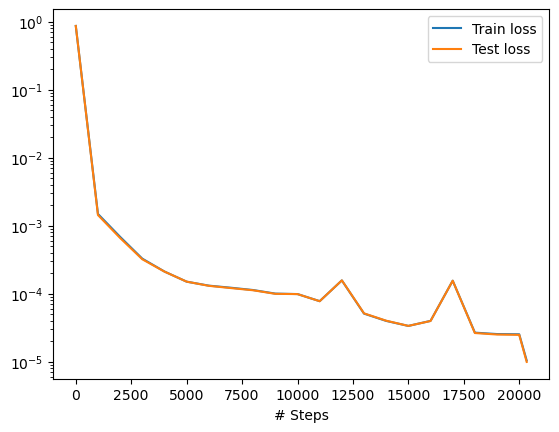

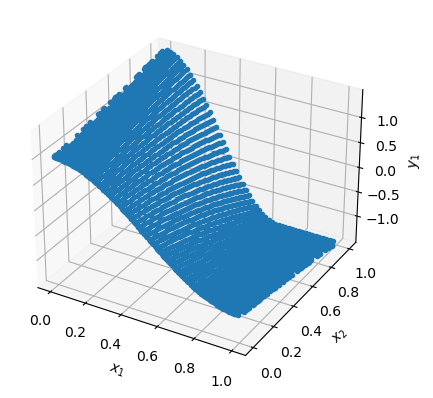

In [35]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

El siguiente ejemplo entrena una red y compara los resultados con la solución analítica.

$\frac{du}{dt} - \alpha \frac{d^2u}{dx^2} = \alpha \left(\frac{\pi}{L}\right)^2 \cos(\frac{\pi x}{L})$

$u(x, 0) = \cos(\frac{\pi x}{L})$

$u_x(0, t) = u_x(L, t) = 0$

$u(x, t) = \cos(\frac{\pi x}{L})$

In [10]:
# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

def heat_eq_exact_solution(x, t):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    return np.cos(np.pi * x / L)

In [11]:
def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

# Generate a dataset with the exact solution (if you dont have one):
gen_exact_solution()

def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx - a * (np.pi / L)**2 * tf.cos(np.pi * x[:, 0:1] / L)


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [12]:
# Initial and boundary conditions:
bc = dde.icbc.NeumannBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.cos(np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

In [13]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [14]:
# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.004613 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.98e+00, 3.70e-03, 5.32e-01]    [7.62e+00, 3.70e-03, 5.32e-01]    []  
1000      [6.49e-04, 4.95e-05, 2.41e-05]    [5.47e-04, 4.95e-05, 2.41e-05]    []  
2000      [1.31e-04, 5.63e-06, 4.78e-06]    [1.01e-04, 5.63e-06, 4.78e-06]    []  
3000      [6.24e-05, 3.22e-06, 1.46e-06]    [5.00e-05, 3.22e-06, 1.46e-06]    []  
4000      [3.98e-05, 2.62e-06, 6.98e-07]    [3.24e-05, 2.62e-06, 6.98e-07]    []  
5000      [2.75e-05, 2.38e-06, 4.22e-07]    [2.24e-05, 2.38e-06, 4.22e-07]    []  
6000      [2.00e-05, 2.16e-06, 2.98e-07]    [1.62e-05, 2.16e-06, 2.98e-07]    []  
7000      [1.49e-05, 1.91e-06, 2.27e-07]    [1.20e-05, 1.91e-06, 2.27e-07]    []  
8000      [1.13e-05, 1.65e-06, 1.88e-07]    [9.04e-06, 1.65e-06, 1.88e-07]    []  
9000      [8.83e-06, 1.40e-06, 1.59e-07]    [6.98e-06, 1.40e-06, 1.59e-07]    []  
10000     [6.98

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


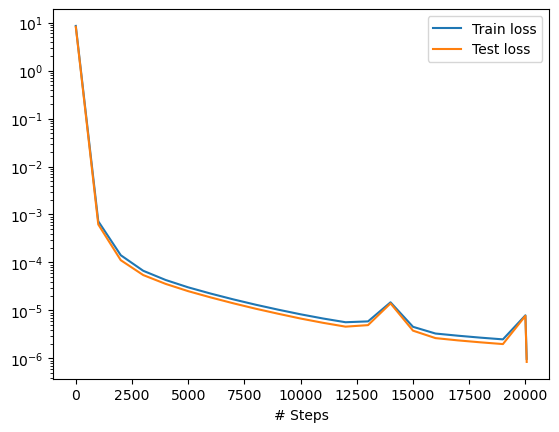

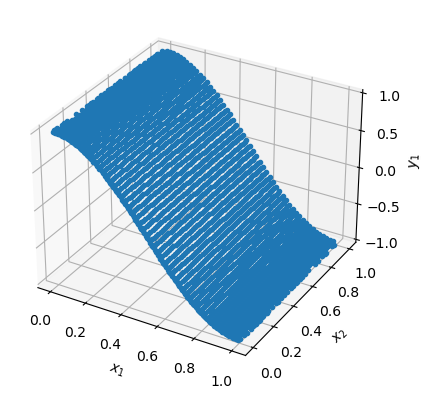

Mean residual: 0.00072602223
L2 relative error: 0.0001035241173269725


In [15]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Se observa que los resultados son muy cercanos a la solución analítica.

Por último, se prueba otro problema con solución exacta:

$\frac{du}{dt} - \alpha \frac{d^2u}{dx^2} = \alpha \left(\frac{\pi}{L}\right)^2 \cos(\frac{\pi x}{L})
+ \alpha \left(\frac{3\pi}{L}\right)^2 t\cos(\frac{3 \pi x}{L}) + \cos(\frac{3\pi x}{L})$

$u(x, 0) = \cos(\frac{\pi x}{L})$

$u_x(0, t) = u_x(L, t) = 0$

$u(x, t) = \cos(\frac{\pi x}{L}) + \cos(\frac{3 \pi x}{L})t$

In [16]:
def heat_eq_exact_solution(x, t):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    return np.cos(np.pi * x / L) + np.cos(3 * np.pi * x / L) * t

In [17]:
def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you dont have one):
gen_exact_solution()

def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx - a * (np.pi / L)**2 * tf.cos(np.pi * x[:, 0:1] / L) - a * (3 * np.pi / L)**2 * x[:, 1:] * tf.cos(3 * np.pi * x[:, 0:1] / L) - tf.cos(3 * np.pi * x[:, 0:1] / L)


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [18]:
# Initial and boundary conditions:
bc = dde.icbc.NeumannBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.cos(np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

In [19]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [20]:
# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.003125 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.34e+02, 3.49e-03, 5.32e-01]    [2.35e+02, 3.49e-03, 5.32e-01]    []  
1000      [1.12e-01, 2.37e-02, 2.23e-03]    [1.06e-01, 2.37e-02, 2.23e-03]    []  
2000      [3.12e-02, 7.02e-03, 3.07e-03]    [2.78e-02, 7.02e-03, 3.07e-03]    []  
3000      [1.71e-02, 4.24e-03, 2.34e-03]    [1.51e-02, 4.24e-03, 2.34e-03]    []  
4000      [1.22e-02, 3.27e-03, 1.66e-03]    [1.07e-02, 3.27e-03, 1.66e-03]    []  
5000      [8.82e-03, 2.30e-03, 1.17e-03]    [7.65e-03, 2.30e-03, 1.17e-03]    []  
6000      [6.95e-03, 1.75e-03, 8.00e-04]    [5.96e-03, 1.75e-03, 8.00e-04]    []  
7000      [5.46e-03, 1.30e-03, 5.80e-04]    [4.51e-03, 1.30e-03, 5.80e-04]    []  
8000      [4.58e-03, 1.02e-03, 4.35e-04]    [3.68e-03, 1.02e-03, 4.35e-04]    []  
9000      [2.46e-02, 4.42e-03, 3.57e-04]    [2.68e-02, 4.42e-03, 3.57e-04]    []  
10000     [3.47

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


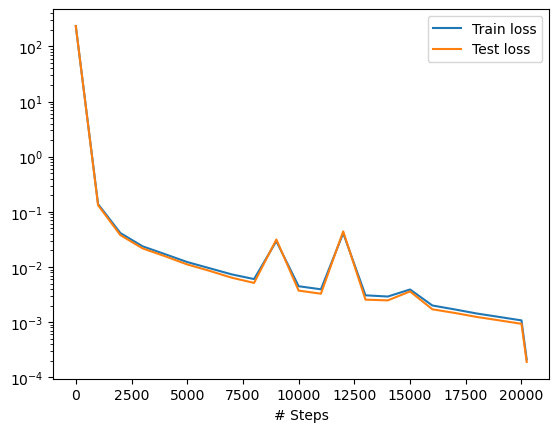

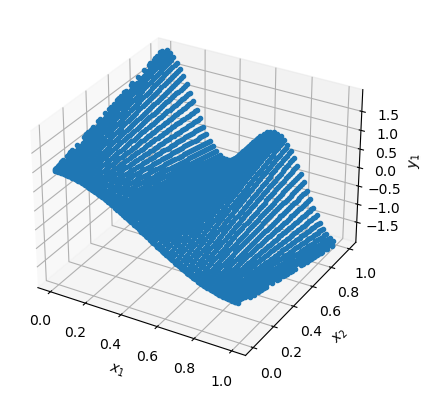

Mean residual: 0.010293311
L2 relative error: 0.0010979680526926466


In [21]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))